# Libs

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input

from matplotlib import pyplot as plt
import numpy as np

import os

2023-04-09 00:08:10.862776: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data

In [3]:
data_dir = "./zalando/"

In [4]:
imsize = 32
batch_size = 32
latent_dim = 100

train_images = tf.keras.utils.image_dataset_from_directory(
    data_dir, label_mode=None, image_size=(imsize,imsize), batch_size=32)
train_images = train_images.map(lambda x: (x - 127.5) / 127.5)
weight_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

Found 5051 files belonging to 1 classes.


2023-04-09 00:08:15.449543: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# NNs

In [65]:
def build_generator():
    
    model = keras.models.Sequential(name='generator')

    model.add(keras.layers.Dense(4*4*256, input_dim=latent_dim))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    
    model.add(keras.layers.Reshape([4,4,256]))

    model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2),
                                           padding='same',kernel_initializer=weight_init,
                                           activation = keras.layers.ReLU()))
    
    model.add(keras.layers.Conv2DTranspose(64, (4,4), strides=(2,2),
                                           padding='same',kernel_initializer=weight_init,
                                           activation = keras.layers.ReLU()))
    
    model.add(keras.layers.Conv2DTranspose(32, (4,4), strides=(2,2),
                                           padding='same',
                                           kernel_initializer=weight_init,
                                           activation = keras.layers.ReLU()))

    model.add(keras.layers.Conv2D(3, (4, 4), padding="same", activation="tanh"))
    
    return model
    
generator = build_generator()

def build_discriminator():
    
    model = keras.models.Sequential(name = 'discriminator')
    
    model.add(keras.layers.Conv2D(128, (4,4), padding='same',
                                 strides=(2,2), input_shape=(imsize, imsize, 3)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(keras.layers.Conv2D(256, (4,4), padding='same', strides=(2,2)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(keras.layers.Conv2D(256, (4,4), padding='same', strides=(2,2)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.3))
    
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    return model

discriminator = build_discriminator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


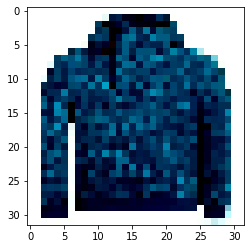

In [6]:
for i in train_images:
    img = i

plt.imshow(img[0])

In [7]:
noise = tf.random.normal(shape=[1, latent_dim])
#img = generator(noise)
discriminator(img[:4])

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.5084534 ],
       [0.497366  ],
       [0.4879597 ],
       [0.46727324]], dtype=float32)>

In [10]:
img[0].shape

TensorShape([32, 32, 3])

## pretrained

In [117]:
base_model = keras.applications.vgg16.VGG16(
    weights='imagenet',
    input_shape=(32,32,3),
    include_top=False
)

for layers in base_model.layers:
    layers.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [118]:
def build_generator():

    model = keras.models.Sequential(name='generator')

    model.add(keras.layers.Dense(32*32*3, input_dim=100))
    model.add(keras.layers.ReLU())
    
    model.add(keras.layers.Reshape([32,32,3]))

    model.add(base_model)

    for f in [512, 256, 128, 64, 32]:
        model.add(keras.layers.Conv2DTranspose(f, (4,4), strides=(2,2),
                                               padding='same',kernel_initializer=weight_init,
                                               activation = keras.layers.ReLU()))
        model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(3, (4, 4), padding="same", activation="tanh"))

    return model

generator = build_generator()

noise = tf.random.normal(shape=(1, 100), seed=42)
imgs = generator(noise)
print(imgs.shape)
discriminator(imgs)

(1, 32, 32, 3)


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49994916]], dtype=float32)>

## triple

In [177]:
# Composed generator
def build_gen_untrainable():
    """
    here an input shape (0,100) is passed thourh vgg
    this part of the net remains untrainable
    """
    model = keras.models.Sequential(name='gen_untrainbale')

    model.add(keras.layers.Dense(32*32*3, input_dim=100))
    model.add(keras.layers.ReLU())
    
    model.add(keras.layers.Reshape([32,32,3]))

    model.add(base_model)

    return model

gen_in = build_gen_untrainable()

def build_gen_trainable():
    """
    here an input from the vgg part is passed
    the trainbale layers
    """
    model = keras.models.Sequential(name='gen_trainbale')
    model.add(keras.layers.InputLayer(input_shape = (1, 1, 512)))
    model.add(keras.layers.Dense(32*32*3))
    for f in [512, 256, 128, 64, 32]:
        model.add(keras.layers.Conv2DTranspose(f, (4,4), strides=(2,2),
                                               padding='same',kernel_initializer=weight_init,
                                               activation = keras.layers.ReLU()))
        model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(3, (4, 4), padding="same", activation="tanh"))

    return model


gen_out = build_gen_trainbale()

mm = keras.models.Sequential([gen_in,gen_out])
noise = tf.random.normal(shape=(1,100))
img = mm(noise)
img.shape

TensorShape([1, 32, 32, 3])

In [ ]:
# Composed discriminator

In [152]:
def build_dis_untrainable():
    """
    here an input shape (0,100) is passed thourh vgg
    this part of the net remains untrainable
    """
    model = keras.models.Sequential(name = 'discriminator')

    model.add(base_model)
    
    return model

dis_in = build_dis_untrainable()

def build_dis_untrainable():
    """
    here an input from the vgg part is passed
    the trainbale layers
    """
    model = keras.models.Sequential(name='trainbale')
    model.add(keras.layers.InputLayer(input_shape = (1, 1, 512)))
    
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(keras.layers.Conv2D(256, (4,4), padding='same', strides=(2,2)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(keras.layers.Conv2D(256, (4,4), padding='same', strides=(2,2)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.3))
    
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    return model

dis_out = build_dis_untrainable()

# dd = keras.Sequential([dis_in,dis_out])
# dd(img)

In [ ]:
class DCGAN(keras.Model):

    def __init__(self, gen_in, gen_out, dis_in, dis_out):
        super(DCGAN, self).__init__()
        self.latent_dim = 100
        self.gen_in = gen_in
        self.gen_out = gen_out
        self.dis_in = dis_in
        self.dis_out = dis_out
        self.dis_loss_metric = keras.metrics.Mean(name="d_loss")
        self.gen_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, gen_out_optim, dis_out_optim, loss):
        super(DCGAN, self).compile()
        self.gen_out_opt = gen_out_optim
        self.dis_out_opt = dis_out_optim
        self.loss = loss

    @property
    def metrics(self):
        return [self.dis_loss_metric, self.gen_loss_metric]
    
    def train_step(self, real_images):
        
        batch_size = tf.shape(real_images)[0]

        with tf.GradientTape() as tape:
            noise = tf.random.normal(shape=(batch_size, self.latent_dim))
            pre = self.gen_in(noise)
            fake_img = self.gen_out(pre, training = True)
            pre = self.dis_in(fake_img)
            predict_on_fake = self.dis_out(pre, training = True)
            fake_labels = tf.zeros((batch_size, 1))
            fake_loss = self.loss(predict_on_fake, fake_labels)
            real_lables = tf.ones((batch_size, 1))
            pre = self.dis_in(real_images, training = True)
            predict_on_real = self.dis_out(pre, training = True)
            real_loss = self.loss(predict_on_real, real_lables)
            total_loss = (fake_loss + real_loss)/2
        grads = tape.gradient(total_loss, self.dis_out .trainable_variables)
        self.dis_out_opt.apply_gradients(zip(grads, self.dis_out.trainable_variables))
        self.dis_loss_metric.update_state(total_loss)

        with tf.GradientTape() as tape:
            pre = self.gen_in(noise)
            fake_img = self.gen_out(pre, training = True)
            pre = self.dis_in(fake_img)
            predict_on_fake = self.dis_out(pre, training = True)
            fake_lables = tf.ones((batch_size, 1))
            total_loss = self.loss(fake_lables, predict_on_fake)

        grads = tape.gradient(total_loss, self.gen_in.trainable_variables)
        self.gen_out_opt.apply_gradients(zip(grads, self.gen_in.trainable_variables))
        self.gen_loss_metric.update_state(total_loss)

        return {"d_loss": self.dis_loss_metric.result(), "g_loss": self.gen_loss_metric.result()}

dcgan = DCGAN(gen_in, gen_out, dis_in, dis_out)

dcgan.compile(
    gen_out_optim =keras.optimizers.Adam(learning_rate=0.008, beta_1 = 0.5),
    dis_out_optim=keras.optimizers.Adam(learning_rate=0.003, beta_1 = 0.5),
    loss=keras.losses.BinaryCrossentropy())

dcgan.fit(train_images, epochs=25)

## triple2

In [173]:
base_model = keras.applications.vgg16.VGG16(
    weights='imagenet',
    input_shape=(32,32,3),
    include_top=False
)

vgg_layers = []
for layer in base_model.layers[:4]:
    layer.trainable = False
    vgg_layers.append(layer)

vgg_layers

In [213]:
# Composed generator
def build_gen_untrainable():
    """
    here an input shape (0,100) is passed thourh vgg
    this part of the net remains untrainable
    """
    model = keras.models.Sequential(name='gen_untrainbale')

    model.add(keras.layers.Dense(32*32*3, input_dim=100))
    model.add(keras.layers.ReLU())
    
    model.add(keras.layers.Reshape([32,32,3]))

    for layer in vgg_layers:
        model.add(layer)

    return model

gen_in = build_gen_untrainable()

def build_gen_trainable():
    """
    here an input from the vgg part is passed
    the trainbale layers
    """
    model = keras.models.Sequential(name='gen_trainbale')
    model.add(keras.layers.InputLayer(input_shape = (16, 16, 64)))
    model.add(keras.layers.Dense(16*16*64))
    model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2),
                                           padding='same',kernel_initializer=weight_init,
                                           activation = keras.layers.ReLU()))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(3, (4, 4), padding="same", activation="tanh"))
    return model

gen_out = build_gen_trainable()

mm = keras.models.Sequential([gen_in, gen_out])
img = mm(noise)
img.shape

TensorShape([1, 32, 32, 3])

In [221]:
def build_dis_untrainable():
    """
    here an input shape (0,100) is passed thourh vgg
    this part of the net remains untrainable
    """
    model = keras.models.Sequential(name = 'dis_untrainbale')
    model.add(keras.layers.InputLayer(input_shape = (32, 32, 3)))
    for layer in vgg_layers:
        model.add(layer)
    
    return model

dis_in = build_dis_untrainable()

def build_dis_trainable():
    """
    here an input from the vgg part is passed
    the trainbale layers
    """
    model = keras.models.Sequential(name='trainbale')
    model.add(keras.layers.InputLayer(input_shape = (16,16,64)))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Conv2D(256, (4,4), padding='same', strides=(2,2)))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    return model

dis_out = build_dis_trainable()

dd = keras.Sequential([dis_in,dis_out])
dd(img)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.99596614]], dtype=float32)>

## triple3

In [229]:
base_model = keras.applications.vgg16.VGG16(
    weights='imagenet',
    input_shape=(32,32,3),
    include_top=False
)

vgg_layers = []
for layer in base_model.layers[:4]:
    layer.trainable = False
    vgg_layers.append(layer)

vgg_layers

# Composed generator
def build_gen_untrainable():
    """
    here an input shape (0,100) is passed thourh vgg
    this part of the net remains untrainable
    """
    model = keras.models.Sequential(name='gen_untrainbale')

    model.add(keras.layers.Dense(32*32*3, input_dim=100))
    model.add(keras.layers.ReLU())
    
    model.add(keras.layers.Reshape([32,32,3]))

    for layer in vgg_layers:
        model.add(layer)

    return model

gen_in = build_gen_untrainable()
for layer in gen_in.layers:
    layer.trainable = False

def build_gen_trainable():
    """
    here an input from the vgg part is passed
    the trainbale layers
    """
    model = keras.models.Sequential(name='gen_trainbale')
    model.add(keras.layers.InputLayer(input_shape = (16, 16, 64)))
    model.add(keras.layers.Dense(16*16*64))
    model.add(keras.layers.Dense(8*8*32))
    model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2),
                                           padding='same',kernel_initializer=weight_init,
                                           activation = keras.layers.ReLU()))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(3, (4, 4), padding="same", activation="tanh"))
    return model

gen_out = build_gen_trainable()

def build_dis_untrainable():
    """
    here an input shape (0,100) is passed thourh vgg
    this part of the net remains untrainable
    """
    model = keras.models.Sequential(name = 'dis_untrainbale')
    model.add(keras.layers.InputLayer(input_shape = (32, 32, 3)))
    for layer in vgg_layers:
        model.add(layer)
    
    return model

dis_in = build_dis_untrainable()
for layer in dis_in.layers:
    layer.trainable = False

def build_dis_untrainable():
    """
    here an input from the vgg part is passed
    the trainbale layers
    """
    model = keras.models.Sequential(name='trainbale')
    model.add(keras.layers.InputLayer(input_shape = (16,16,64)))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Conv2D(128, (4,4), padding='same', strides=(2,2)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    return model

dis_out = build_dis_untrainable()

# DCGAN

In [135]:
class DCGAN(keras.Model):

    def __init__(self, generator, discriminator):
        super(DCGAN, self).__init__()
        self.latent_dim = 100
        self.generator = generator
        self.discriminator = discriminator
        self.dis_loss_metric = keras.metrics.Mean(name="d_loss")
        self.gen_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, gen_optim, dis_optim, loss):
        super(DCGAN, self).compile()
        self.gen_opt = gen_optim
        self.dis_opt = dis_optim
        self.loss = loss

    @property
    def metrics(self):
        return [self.dis_loss_metric, self.gen_loss_metric]
    
    def train_step(self, real_images):
        
        batch_size = tf.shape(real_images)[0]

        with tf.GradientTape() as tape:
            noise = tf.random.normal(shape=(batch_size, self.latent_dim))
            fake_img = self.generator(noise)
            predict_on_fake = self.discriminator(fake_img, training = True)
            fake_labels = tf.zeros((batch_size, 1))
            fake_loss = self.loss(predict_on_fake, fake_labels)
            real_lables = tf.ones((batch_size, 1))
            predict_on_real = self.discriminator(real_images, training = True)
            real_loss = self.loss(predict_on_real, real_lables)
            total_loss = (fake_loss + real_loss)/2
        grads = tape.gradient(total_loss, self.discriminator.trainable_variables)
        self.dis_opt.apply_gradients(zip(grads, self.discriminator.trainable_variables))
        self.dis_loss_metric.update_state(total_loss)

        with tf.GradientTape() as tape:

            noise = tf.random.normal(shape=(batch_size, self.latent_dim))
            fake_img = self.generator(noise, training = True)
            prediction_on_fake = self.discriminator(fake_img, training = False)
            fake_lables = tf.ones((batch_size, 1))
            total_loss = self.loss(fake_lables, prediction_on_fake)

        grads = tape.gradient(total_loss, self.generator.trainable_variables)
        self.gen_opt.apply_gradients(zip(grads, self.generator.trainable_variables))
        self.gen_loss_metric.update_state(total_loss)

        return {"d_loss": self.dis_loss_metric.result(), "g_loss": self.gen_loss_metric.result()}

dcgan = DCGAN(generator=generator, discriminator=discriminator)

dcgan.compile(
    gen_optim=keras.optimizers.Adam(learning_rate=0.008, beta_1 = 0.5),
    dis_optim=keras.optimizers.Adam(learning_rate=0.003, beta_1 = 0.5),  
    loss=keras.losses.BinaryCrossentropy())

dcgan.fit(train_images, epochs=25)

Epoch 1/25
  7/158 [>.............................] - ETA: 1:14 - d_loss: 7.7125 - g_loss: 4.4713e-04

KeyboardInterrupt: 